# 🌀 RealNVP

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/06_normflow/01_realnvp/realnvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩일 경우 노트북에서 output 디렉토리를 만듭니다.
if 'google.colab' in sys.modules:
    !mkdir output

이 노트북에서는 데모 데이터셋의 분포를 예측하기 위해 RealNVP 신경망을 훈련합니다.

이 코드는 케라스 웹 사이트에 있는 Mandolini Giorgio Maria, Sanna Daniele and Zannini Quirini Giorgio의 훌륭한 [RealNVP 튜토리얼](https://keras.io/examples/generative/real_nvp/)을 참고했습니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)
import tensorflow_probability as tfp

## 0. 파라미터 <a name="parameters"></a>

In [3]:
COUPLING_DIM = 256
COUPLING_LAYERS = 6
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

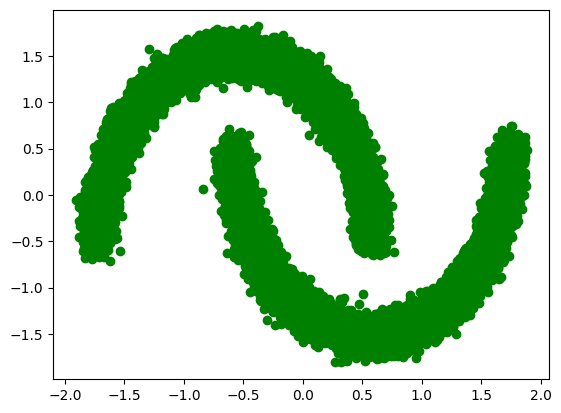

In [4]:
# 데이터 로드
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()

## 2. RealNVP 네트워크 구축 <a name="build"></a>

In [5]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=input_dim)

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [6]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

## 3. RealNVP 네트워크 훈련 <a name="train"></a>

In [7]:
# 모델 컴파일 및 훈련
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [8]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # 데이터에서 잠재 공간까지.
        z, _ = model(normalized_data)

        # 잠재 공간에서 데이터까지.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_samples=3000)

Epoch 1/300
  5/118 [>.............................] - ETA: 3s - loss: 2.7564

117/118 [============================>.] - ETA: 0s - loss: 2.4503
Saved to ./output/generated_img_000.png


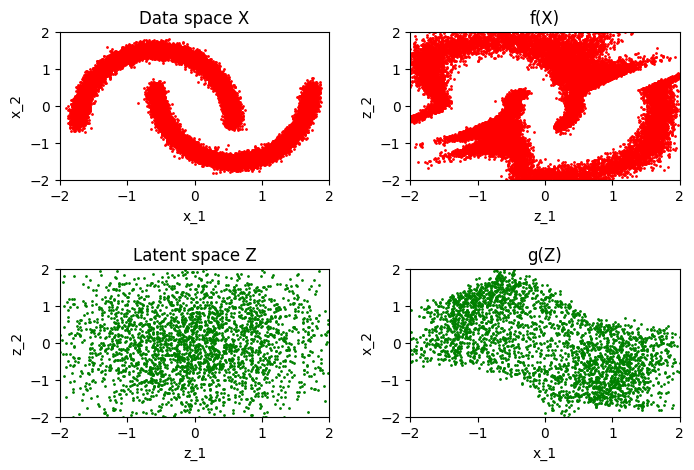

118/118 [==============================] - 35s 44ms/step - loss: 2.4480
Epoch 2/300
118/118 [==============================] - 2s 19ms/step - loss: 2.1193
Epoch 3/300
118/118 [==============================] - 2s 18ms/step - loss: 1.9111
Epoch 4/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7764
Epoch 5/300
118/118 [==============================] - 3s 23ms/step - loss: 1.5826
Epoch 6/300
118/118 [==============================] - 2s 19ms/step - loss: 1.4842
Epoch 7/300
118/118 [==============================] - 2s 18ms/step - loss: 1.4563
Epoch 8/300
118/118 [==============================] - 2s 21ms/step - loss: 1.4986
Epoch 9/300
118/118 [==============================] - 2s 20ms/step - loss: 1.3871
Epoch 10/300
118/118 [==============================] - 3s 23ms/step - loss: 1.3906
Epoch 11/300
118/118 [==============================] - ETA: 0s - loss: 1.3998
Saved to ./output/generated_img_010.png


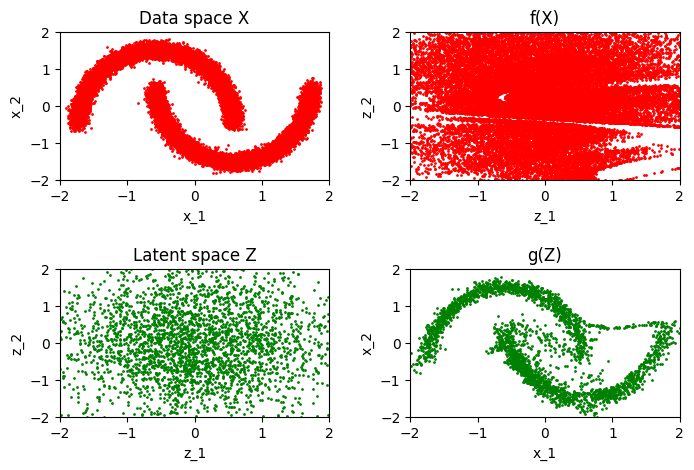

118/118 [==============================] - 4s 32ms/step - loss: 1.3998
Epoch 12/300
118/118 [==============================] - 2s 19ms/step - loss: 1.3637
Epoch 13/300
118/118 [==============================] - 2s 19ms/step - loss: 1.3536
Epoch 14/300
118/118 [==============================] - 3s 24ms/step - loss: 1.3518
Epoch 15/300
118/118 [==============================] - 2s 19ms/step - loss: 1.3515
Epoch 16/300
118/118 [==============================] - 2s 19ms/step - loss: 1.3403
Epoch 17/300
118/118 [==============================] - 2s 19ms/step - loss: 1.3390
Epoch 18/300
118/118 [==============================] - 2s 19ms/step - loss: 1.3113
Epoch 19/300
118/118 [==============================] - 3s 24ms/step - loss: 1.3012
Epoch 20/300
118/118 [==============================] - 2s 20ms/step - loss: 1.3049
Epoch 21/300
118/118 [==============================] - ETA: 0s - loss: 1.3098
Saved to ./output/generated_img_020.png


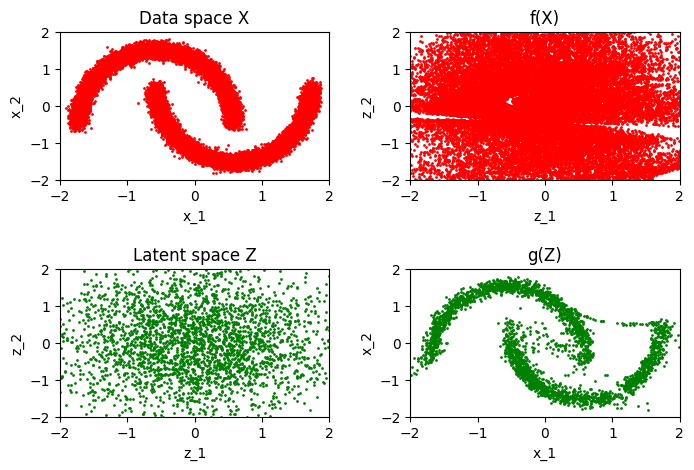

118/118 [==============================] - 5s 43ms/step - loss: 1.3098
Epoch 22/300
118/118 [==============================] - 3s 25ms/step - loss: 1.2949
Epoch 23/300
118/118 [==============================] - 3s 25ms/step - loss: 1.2967
Epoch 24/300
118/118 [==============================] - 2s 19ms/step - loss: 1.3116
Epoch 25/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2922
Epoch 26/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2890
Epoch 27/300
118/118 [==============================] - 2s 19ms/step - loss: 1.3119
Epoch 28/300
118/118 [==============================] - 3s 25ms/step - loss: 1.3116
Epoch 29/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2938
Epoch 30/300
118/118 [==============================] - 2s 20ms/step - loss: 1.3015
Epoch 31/300
118/118 [==============================] - ETA: 0s - loss: 1.2841
Saved to ./output/generated_img_030.png


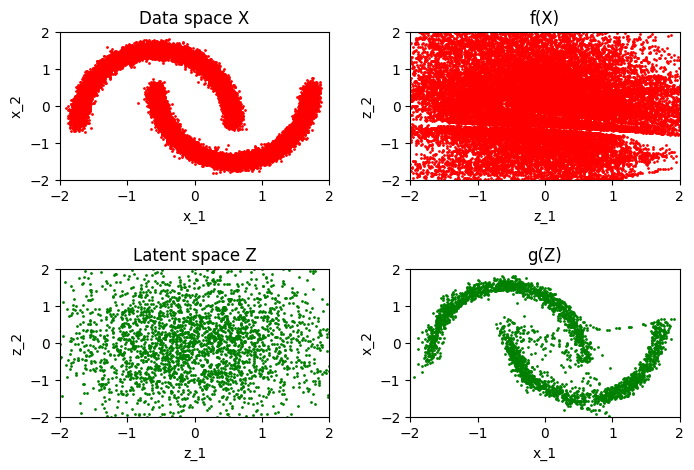

118/118 [==============================] - 4s 33ms/step - loss: 1.2841
Epoch 32/300
118/118 [==============================] - 3s 26ms/step - loss: 1.3111
Epoch 33/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2949
Epoch 34/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2980
Epoch 35/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2901
Epoch 36/300
118/118 [==============================] - 2s 19ms/step - loss: 1.3040
Epoch 37/300
118/118 [==============================] - 3s 25ms/step - loss: 1.2744
Epoch 38/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2786
Epoch 39/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2968
Epoch 40/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2768
Epoch 41/300
118/118 [==============================] - ETA: 0s - loss: 1.3509
Saved to ./output/generated_img_040.png


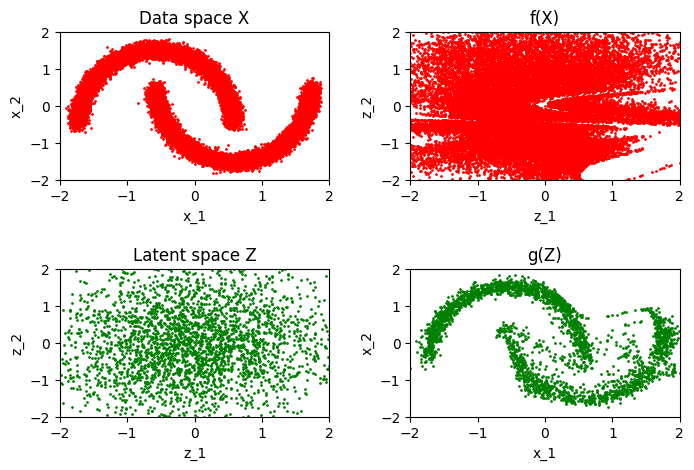

118/118 [==============================] - 4s 34ms/step - loss: 1.3509
Epoch 42/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2988
Epoch 43/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2932
Epoch 44/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2751
Epoch 45/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2811
Epoch 46/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2604
Epoch 47/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2660
Epoch 48/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2494
Epoch 49/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2532
Epoch 50/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2449
Epoch 51/300
117/118 [============================>.] - ETA: 0s - loss: 1.2512
Saved to ./output/generated_img_050.png


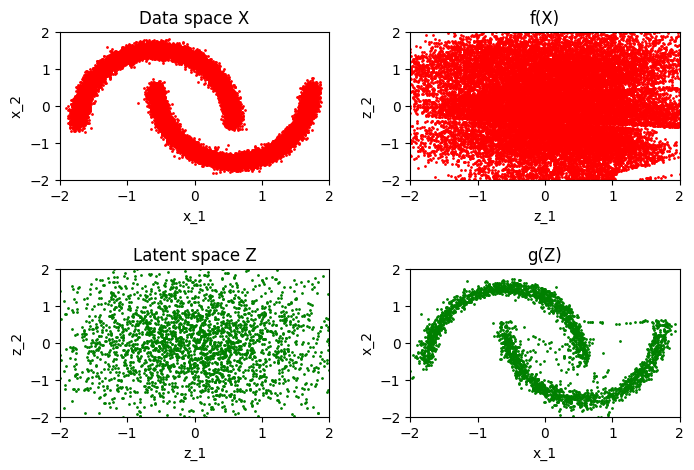

118/118 [==============================] - 4s 37ms/step - loss: 1.2528
Epoch 52/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2539
Epoch 53/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2521
Epoch 54/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2755
Epoch 55/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2752
Epoch 56/300
118/118 [==============================] - 3s 26ms/step - loss: 1.2884
Epoch 57/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2843
Epoch 58/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2813
Epoch 59/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2738
Epoch 60/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2990
Epoch 61/300
116/118 [============================>.] - ETA: 0s - loss: 1.2607
Saved to ./output/generated_img_060.png


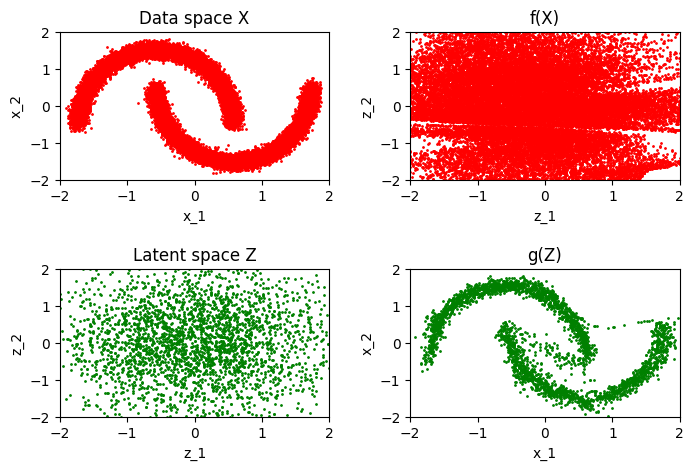

118/118 [==============================] - 4s 38ms/step - loss: 1.2625
Epoch 62/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2589
Epoch 63/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2952
Epoch 64/300
118/118 [==============================] - 2s 20ms/step - loss: 1.4668
Epoch 65/300
118/118 [==============================] - 3s 26ms/step - loss: 1.3202
Epoch 66/300
118/118 [==============================] - 2s 20ms/step - loss: 1.3122
Epoch 67/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2883
Epoch 68/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2700
Epoch 69/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2613
Epoch 70/300
118/118 [==============================] - 3s 26ms/step - loss: 1.2611
Epoch 71/300
116/118 [============================>.] - ETA: 0s - loss: 1.2590
Saved to ./output/generated_img_070.png


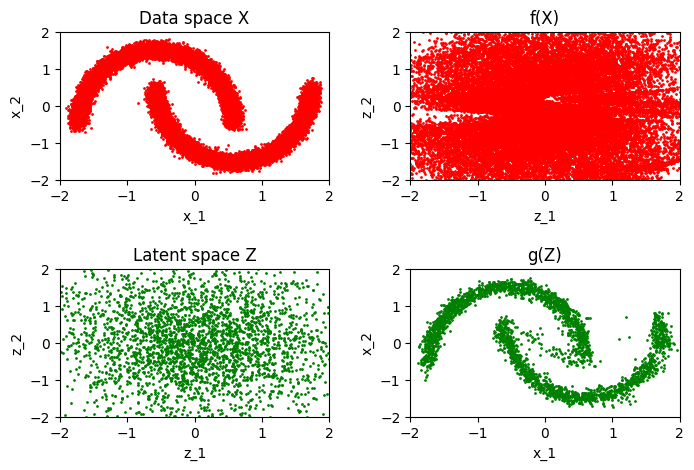

118/118 [==============================] - 4s 34ms/step - loss: 1.2580
Epoch 72/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2430
Epoch 73/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2443
Epoch 74/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2407
Epoch 75/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2355
Epoch 76/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2341
Epoch 77/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2361
Epoch 78/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2476
Epoch 79/300
118/118 [==============================] - 3s 26ms/step - loss: 1.2479
Epoch 80/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2563
Epoch 81/300
117/118 [============================>.] - ETA: 0s - loss: 1.2509
Saved to ./output/generated_img_080.png


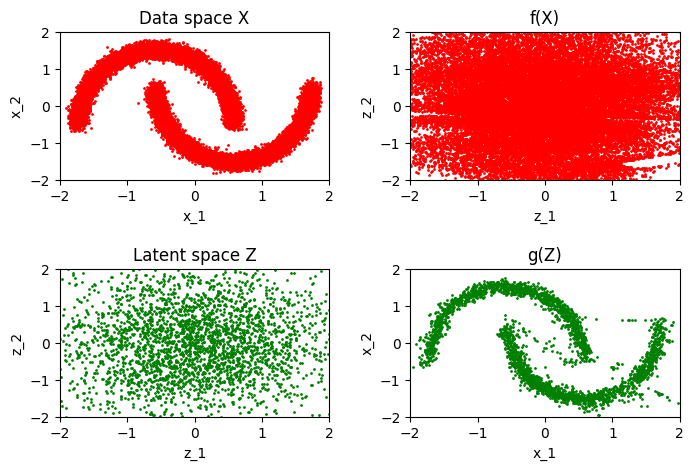

118/118 [==============================] - 4s 32ms/step - loss: 1.2494
Epoch 82/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2375
Epoch 83/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2395
Epoch 84/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2787
Epoch 85/300
118/118 [==============================] - 2s 19ms/step - loss: 1.2520
Epoch 86/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2521
Epoch 87/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2442
Epoch 88/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2415
Epoch 89/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2333
Epoch 90/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2366
Epoch 91/300
117/118 [============================>.] - ETA: 0s - loss: 1.2439
Saved to ./output/generated_img_090.png


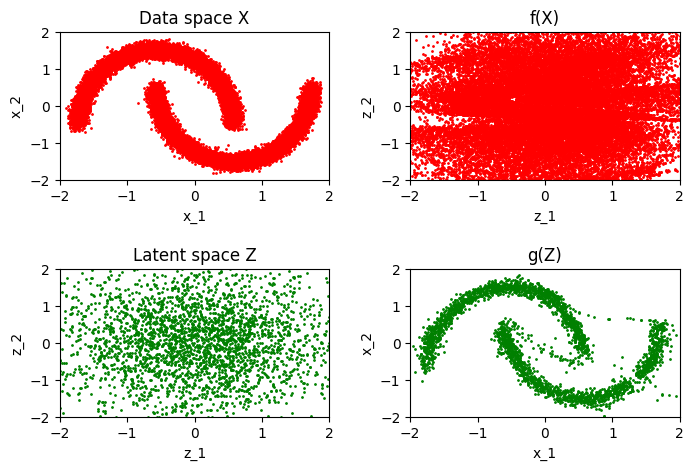

118/118 [==============================] - 4s 35ms/step - loss: 1.2427
Epoch 92/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2291
Epoch 93/300
118/118 [==============================] - 3s 26ms/step - loss: 1.2295
Epoch 94/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2232
Epoch 95/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2295
Epoch 96/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2510
Epoch 97/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2440
Epoch 98/300
118/118 [==============================] - 3s 27ms/step - loss: 1.2365
Epoch 99/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2440
Epoch 100/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2406
Epoch 101/300
118/118 [==============================] - ETA: 0s - loss: 1.2474
Saved to ./output/generated_img_100.png


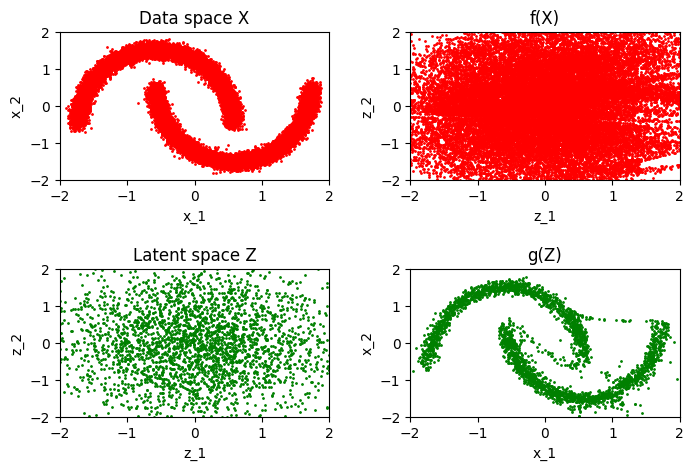

118/118 [==============================] - 4s 37ms/step - loss: 1.2474
Epoch 102/300
118/118 [==============================] - 3s 25ms/step - loss: 1.2451
Epoch 103/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2508
Epoch 104/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2317
Epoch 105/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2343
Epoch 106/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2275
Epoch 107/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2311
Epoch 108/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2308
Epoch 109/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2258
Epoch 110/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2310
Epoch 111/300
117/118 [============================>.] - ETA: 0s - loss: 1.2464
Saved to ./output/generated_img_110.png


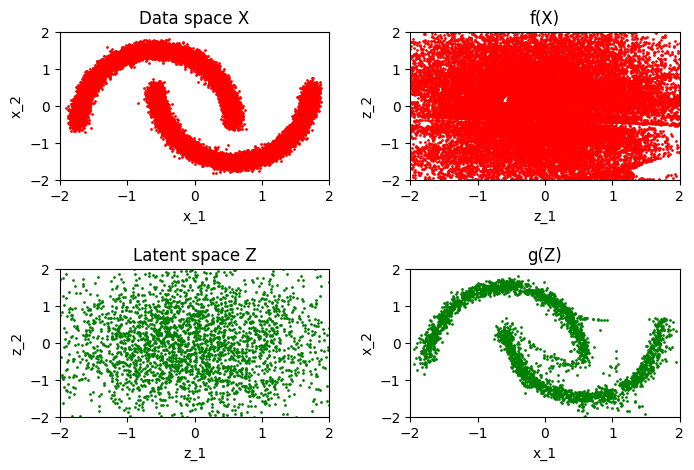

118/118 [==============================] - 5s 40ms/step - loss: 1.2462
Epoch 112/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2395
Epoch 113/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2491
Epoch 114/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2483
Epoch 115/300
118/118 [==============================] - 3s 26ms/step - loss: 1.2413
Epoch 116/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2454
Epoch 117/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2250
Epoch 118/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2334
Epoch 119/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2300
Epoch 120/300
118/118 [==============================] - 4s 31ms/step - loss: 1.2221
Epoch 121/300
117/118 [============================>.] - ETA: 0s - loss: 1.2283
Saved to ./output/generated_img_120.png


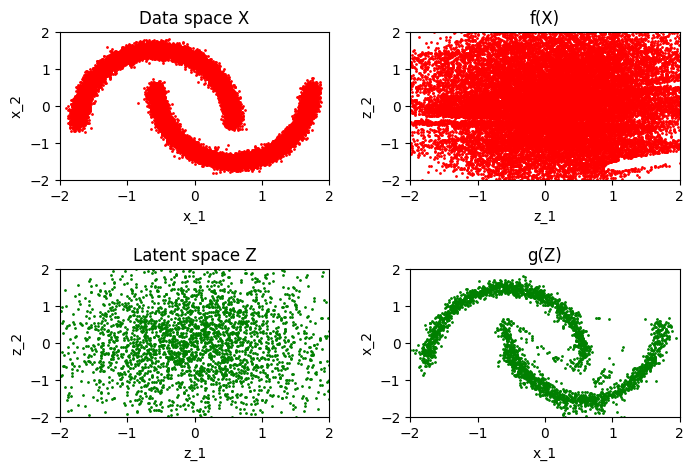

118/118 [==============================] - 4s 35ms/step - loss: 1.2271
Epoch 122/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2757
Epoch 123/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2738
Epoch 124/300
118/118 [==============================] - 3s 28ms/step - loss: 1.2630
Epoch 125/300
118/118 [==============================] - 2s 21ms/step - loss: 1.3024
Epoch 126/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2730
Epoch 127/300
118/118 [==============================] - 3s 22ms/step - loss: 1.3056
Epoch 128/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2776
Epoch 129/300
118/118 [==============================] - 3s 27ms/step - loss: 1.2517
Epoch 130/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2615
Epoch 131/300
117/118 [============================>.] - ETA: 0s - loss: 1.2586
Saved to ./output/generated_img_130.png


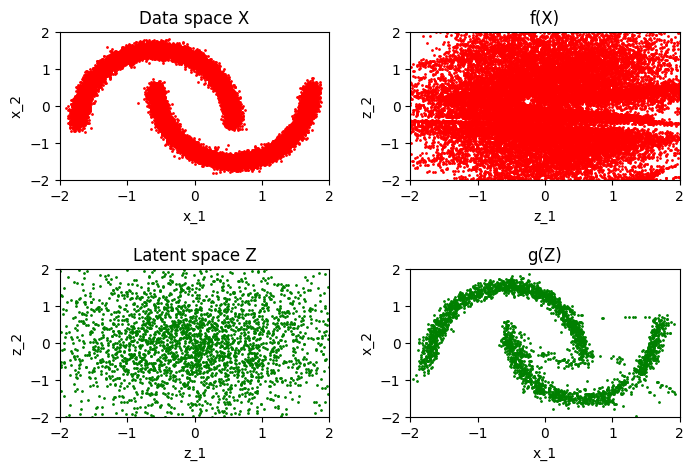

118/118 [==============================] - 4s 35ms/step - loss: 1.2602
Epoch 132/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2648
Epoch 133/300
118/118 [==============================] - 3s 28ms/step - loss: 1.2250
Epoch 134/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2323
Epoch 135/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2400
Epoch 136/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2404
Epoch 137/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2678
Epoch 138/300
118/118 [==============================] - 3s 26ms/step - loss: 1.2783
Epoch 139/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2742
Epoch 140/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2503
Epoch 141/300
118/118 [==============================] - ETA: 0s - loss: 1.2528
Saved to ./output/generated_img_140.png


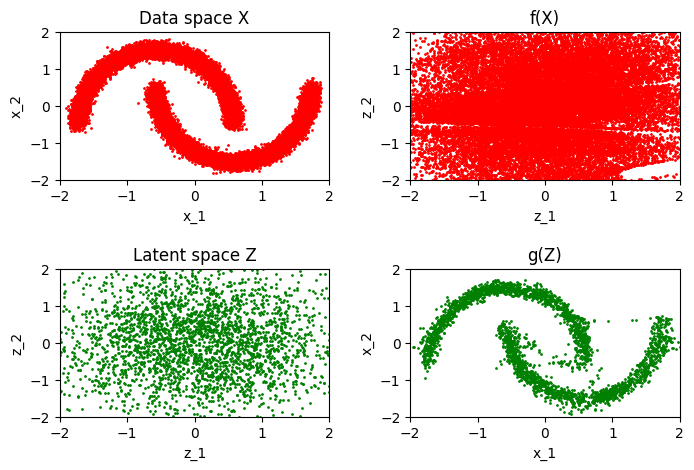

118/118 [==============================] - 4s 35ms/step - loss: 1.2528
Epoch 142/300
118/118 [==============================] - 3s 29ms/step - loss: 1.2396
Epoch 143/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2437
Epoch 144/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2730
Epoch 145/300
118/118 [==============================] - 2s 20ms/step - loss: 1.2456
Epoch 146/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2356
Epoch 147/300
118/118 [==============================] - 3s 28ms/step - loss: 1.2308
Epoch 148/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2383
Epoch 149/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2991
Epoch 150/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2585
Epoch 151/300
118/118 [==============================] - ETA: 0s - loss: 1.2512
Saved to ./output/generated_img_150.png


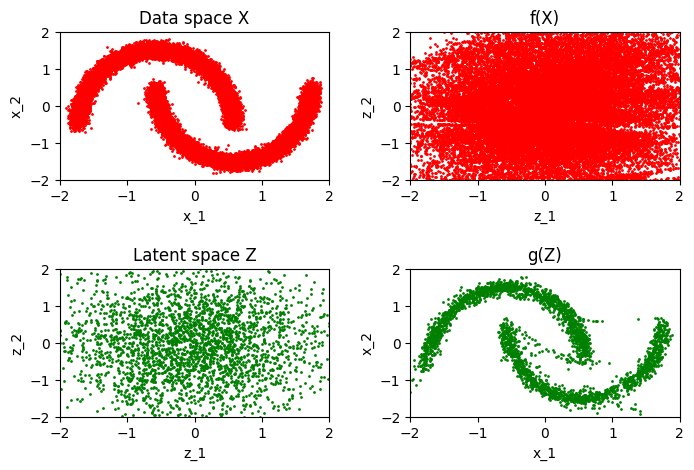

118/118 [==============================] - 5s 39ms/step - loss: 1.2512
Epoch 152/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2437
Epoch 153/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2496
Epoch 154/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2322
Epoch 155/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2242
Epoch 156/300
118/118 [==============================] - 3s 25ms/step - loss: 1.2303
Epoch 157/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2285
Epoch 158/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2414
Epoch 159/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2333
Epoch 160/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2176
Epoch 161/300
117/118 [============================>.] - ETA: 0s - loss: 1.2263
Saved to ./output/generated_img_160.png


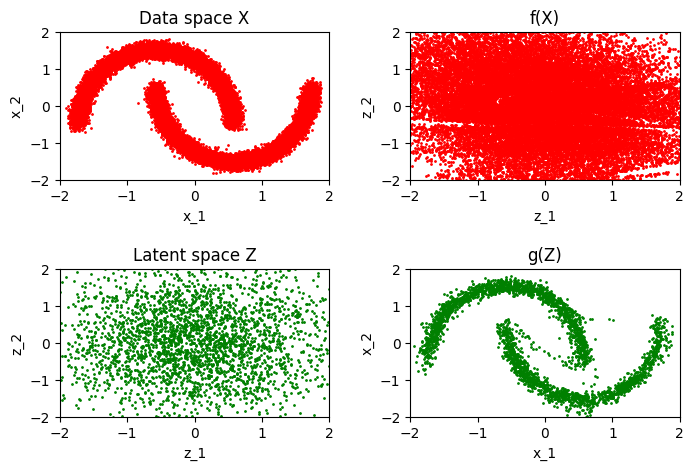

118/118 [==============================] - 4s 38ms/step - loss: 1.2259
Epoch 162/300
118/118 [==============================] - 3s 25ms/step - loss: 1.2160
Epoch 163/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2263
Epoch 164/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2290
Epoch 165/300
118/118 [==============================] - 3s 26ms/step - loss: 1.2425
Epoch 166/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2270
Epoch 167/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2574
Epoch 168/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2648
Epoch 169/300
118/118 [==============================] - 3s 25ms/step - loss: 1.2344
Epoch 170/300
118/118 [==============================] - 3s 24ms/step - loss: 1.3538
Epoch 171/300
117/118 [============================>.] - ETA: 0s - loss: 1.3295
Saved to ./output/generated_img_170.png


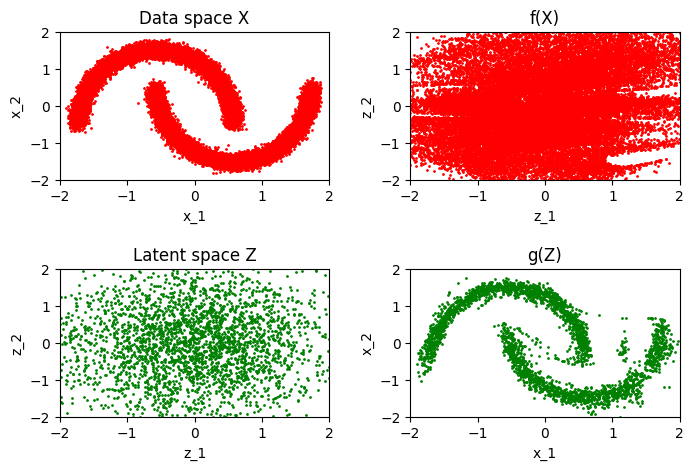

118/118 [==============================] - 4s 33ms/step - loss: 1.3303
Epoch 172/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2697
Epoch 173/300
118/118 [==============================] - 3s 25ms/step - loss: 1.2935
Epoch 174/300
118/118 [==============================] - 3s 26ms/step - loss: 1.2708
Epoch 175/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2471
Epoch 176/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2476
Epoch 177/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2498
Epoch 178/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2537
Epoch 179/300
118/118 [==============================] - 3s 26ms/step - loss: 1.3194
Epoch 180/300
118/118 [==============================] - 3s 21ms/step - loss: 1.3225
Epoch 181/300
118/118 [==============================] - ETA: 0s - loss: 1.2232
Saved to ./output/generated_img_180.png


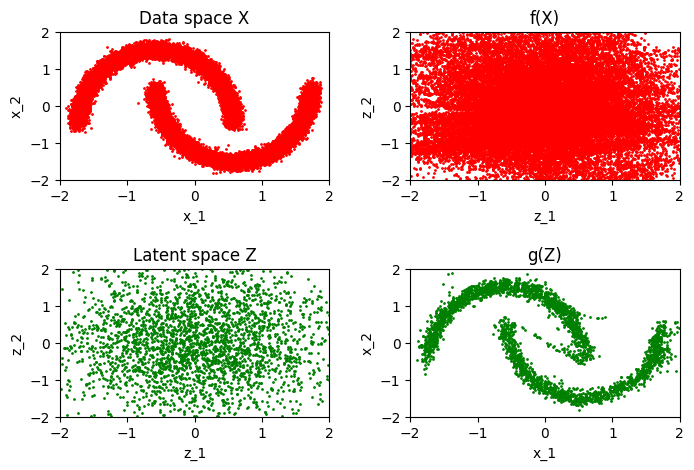

118/118 [==============================] - 4s 35ms/step - loss: 1.2232
Epoch 182/300
118/118 [==============================] - 3s 25ms/step - loss: 1.2146
Epoch 183/300
118/118 [==============================] - 3s 29ms/step - loss: 1.2016
Epoch 184/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2002
Epoch 185/300
118/118 [==============================] - 3s 21ms/step - loss: 1.1908
Epoch 186/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1948
Epoch 187/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1915
Epoch 188/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2010
Epoch 189/300
118/118 [==============================] - 2s 21ms/step - loss: 1.1808
Epoch 190/300
118/118 [==============================] - 3s 21ms/step - loss: 1.1834
Epoch 191/300
117/118 [============================>.] - ETA: 0s - loss: 1.1933
Saved to ./output/generated_img_190.png


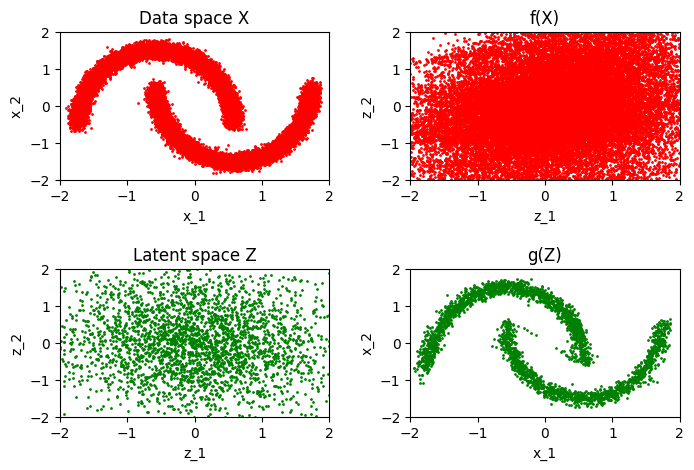

118/118 [==============================] - 4s 37ms/step - loss: 1.1943
Epoch 192/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1772
Epoch 193/300
118/118 [==============================] - 3s 21ms/step - loss: 1.1792
Epoch 194/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1747
Epoch 195/300
118/118 [==============================] - 2s 21ms/step - loss: 1.1783
Epoch 196/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1700
Epoch 197/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1742
Epoch 198/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1822
Epoch 199/300
118/118 [==============================] - 3s 21ms/step - loss: 1.1689
Epoch 200/300
118/118 [==============================] - 2s 21ms/step - loss: 1.1732
Epoch 201/300
118/118 [==============================] - ETA: 0s - loss: 1.1718
Saved to ./output/generated_img_200.png


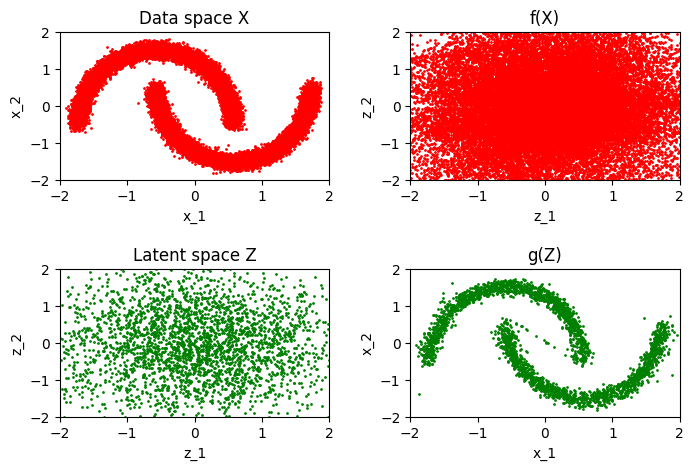

118/118 [==============================] - 5s 44ms/step - loss: 1.1718
Epoch 202/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1665
Epoch 203/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1689
Epoch 204/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1715
Epoch 205/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1749
Epoch 206/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1763
Epoch 207/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1723
Epoch 208/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1677
Epoch 209/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1621
Epoch 210/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1620
Epoch 211/300
118/118 [==============================] - ETA: 0s - loss: 1.1683
Saved to ./output/generated_img_210.png


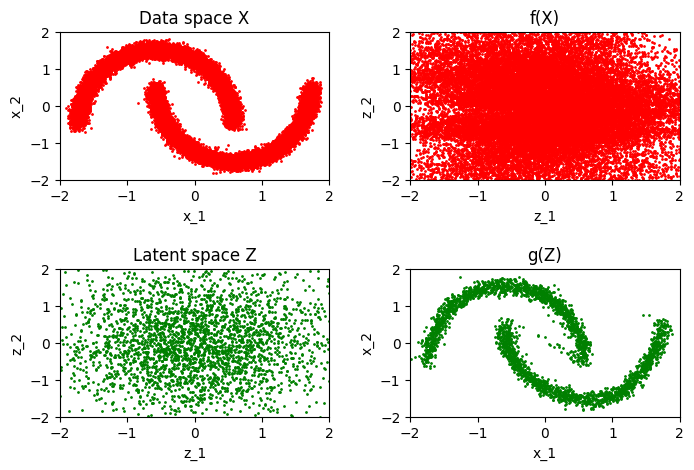

118/118 [==============================] - 4s 34ms/step - loss: 1.1683
Epoch 212/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1717
Epoch 213/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1730
Epoch 214/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1618
Epoch 215/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1692
Epoch 216/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1640
Epoch 217/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1690
Epoch 218/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1760
Epoch 219/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1632
Epoch 220/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1655
Epoch 221/300
116/118 [============================>.] - ETA: 0s - loss: 1.1675
Saved to ./output/generated_img_220.png


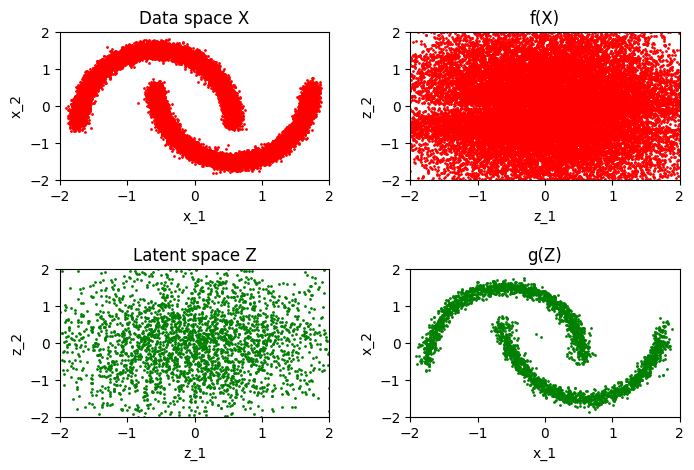

118/118 [==============================] - 4s 37ms/step - loss: 1.1677
Epoch 222/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1659
Epoch 223/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1615
Epoch 224/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1677
Epoch 225/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1654
Epoch 226/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1721
Epoch 227/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1601
Epoch 228/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1751
Epoch 229/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1672
Epoch 230/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1648
Epoch 231/300
117/118 [============================>.] - ETA: 0s - loss: 1.1640
Saved to ./output/generated_img_230.png


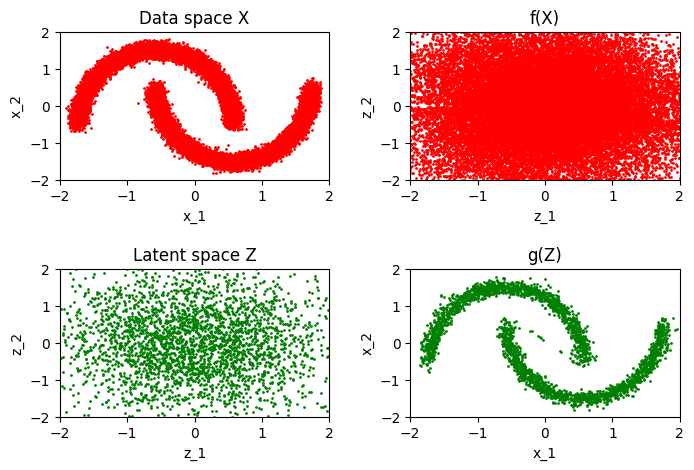

118/118 [==============================] - 5s 41ms/step - loss: 1.1640
Epoch 232/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1654
Epoch 233/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1635
Epoch 234/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1664
Epoch 235/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1681
Epoch 236/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1647
Epoch 237/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1669
Epoch 238/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1644
Epoch 239/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1703
Epoch 240/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1605
Epoch 241/300
117/118 [============================>.] - ETA: 0s - loss: 1.1616
Saved to ./output/generated_img_240.png


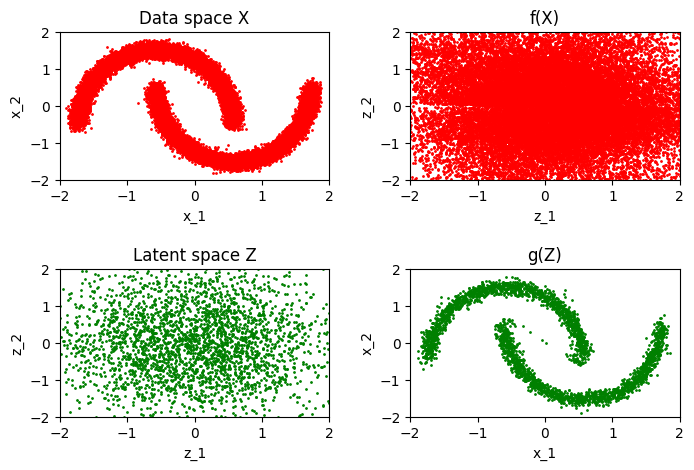

118/118 [==============================] - 5s 38ms/step - loss: 1.1624
Epoch 242/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1592
Epoch 243/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1629
Epoch 244/300
118/118 [==============================] - 4s 32ms/step - loss: 1.1607
Epoch 245/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1614
Epoch 246/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1602
Epoch 247/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1587
Epoch 248/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1581
Epoch 249/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1606
Epoch 250/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1562
Epoch 251/300
117/118 [============================>.] - ETA: 0s - loss: 1.1623
Saved to ./output/generated_img_250.png


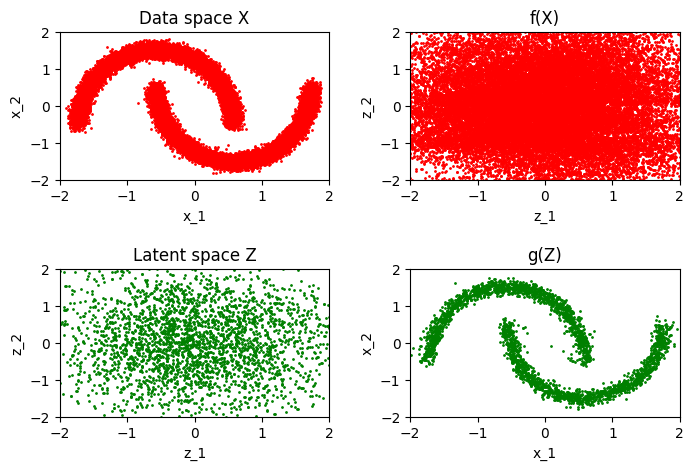

118/118 [==============================] - 5s 40ms/step - loss: 1.1602
Epoch 252/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1654
Epoch 253/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1629
Epoch 254/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1686
Epoch 255/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1643
Epoch 256/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1622
Epoch 257/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1666
Epoch 258/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1611
Epoch 259/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1590
Epoch 260/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1570
Epoch 261/300
118/118 [==============================] - ETA: 0s - loss: 1.1548
Saved to ./output/generated_img_260.png


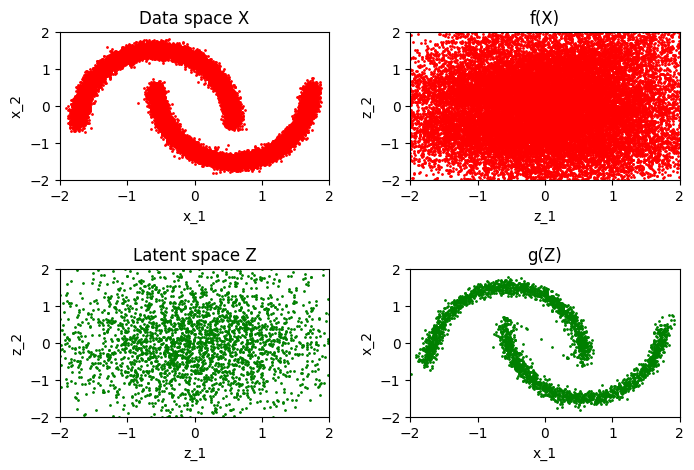

118/118 [==============================] - 5s 42ms/step - loss: 1.1548
Epoch 262/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1581
Epoch 263/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1571
Epoch 264/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1716
Epoch 265/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1606
Epoch 266/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1608
Epoch 267/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1559
Epoch 268/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1627
Epoch 269/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1569
Epoch 270/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1578
Epoch 271/300
116/118 [============================>.] - ETA: 0s - loss: 1.1598
Saved to ./output/generated_img_270.png


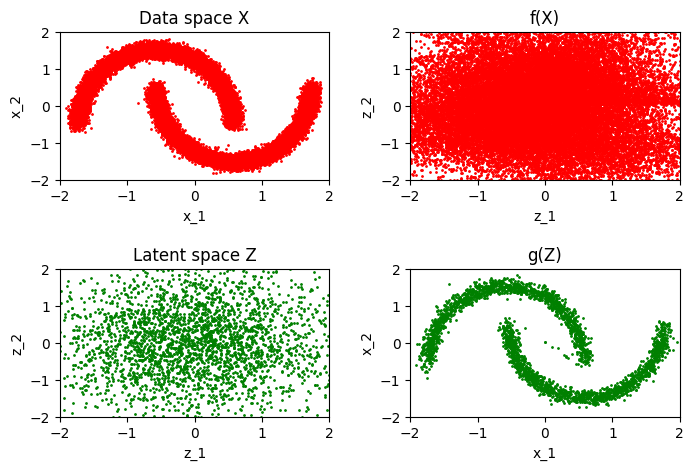

118/118 [==============================] - 4s 36ms/step - loss: 1.1583
Epoch 272/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1602
Epoch 273/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1547
Epoch 274/300
118/118 [==============================] - 4s 32ms/step - loss: 1.1499
Epoch 275/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1597
Epoch 276/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1588
Epoch 277/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1554
Epoch 278/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1582
Epoch 279/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1548
Epoch 280/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1581
Epoch 281/300
118/118 [==============================] - ETA: 0s - loss: 1.1550
Saved to ./output/generated_img_280.png


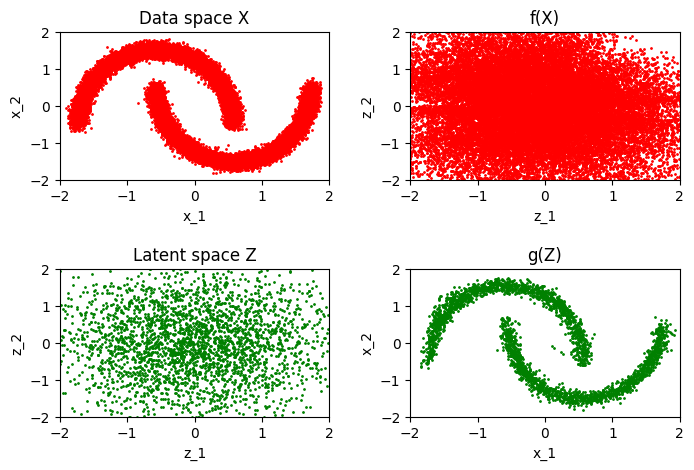

118/118 [==============================] - 5s 41ms/step - loss: 1.1550
Epoch 282/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1587
Epoch 283/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1555
Epoch 284/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1578
Epoch 285/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1507
Epoch 286/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1554
Epoch 287/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1581
Epoch 288/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1629
Epoch 289/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1591
Epoch 290/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1564
Epoch 291/300
118/118 [==============================] - ETA: 0s - loss: 1.1547
Saved to ./output/generated_img_290.png


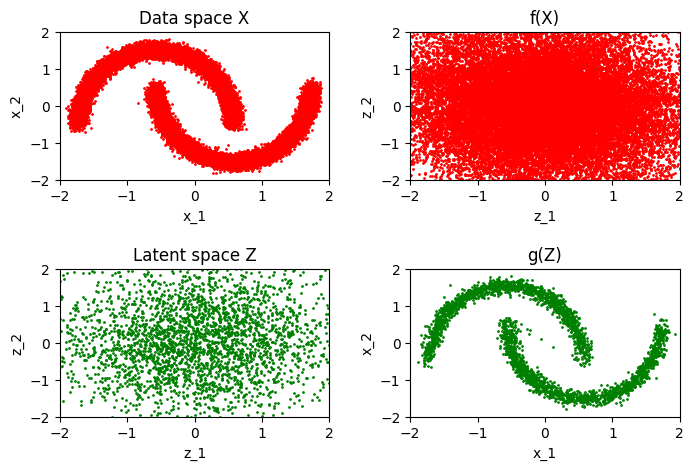

118/118 [==============================] - 5s 43ms/step - loss: 1.1547
Epoch 292/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1557
Epoch 293/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1536
Epoch 294/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1548
Epoch 295/300
118/118 [==============================] - 4s 32ms/step - loss: 1.1519
Epoch 296/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1521
Epoch 297/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1629
Epoch 298/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1537
Epoch 299/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1516
Epoch 300/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1509


In [9]:
model.fit(
    normalized_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. 이미지 생성 <a name="generate"></a>

In [10]:
x, z, samples = img_generator_callback.generate()

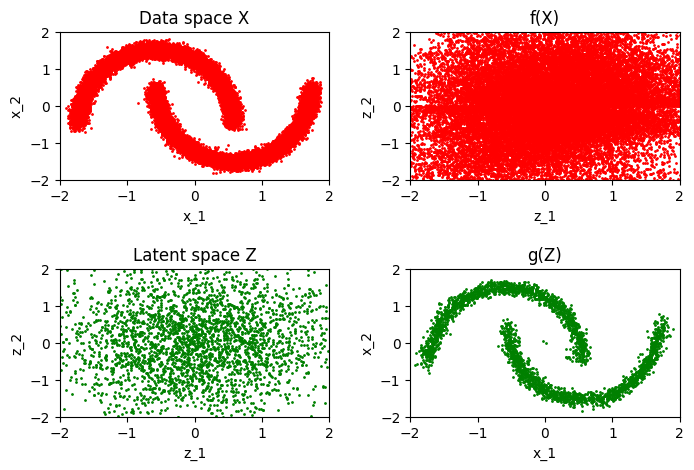

In [11]:
img_generator_callback.display(x, z, samples)